# Lesson 2: Deploy an image classifier

Tasks:
1. Train a simple image classifier
2. Deploy the model to a web service

In [3]:
from pathlib import Path
from PIL import Image
from typing import List

## Download custom dataset

In [4]:
animals = 'zebra','horse'
data_dir = Path('data/animals')
data_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
DOWNLOAD_DATA = False

from duckduckgo_search import DDGS
from fastai.vision.utils import download_images
from time import sleep

def search_images(term, max_images=30) -> List[str]:
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(term, max_results=max_images)
        return [x["image"] for x in ddgs_images_gen]

if DOWNLOAD_DATA:
    for nm in animals:
        dest = (data_dir/nm)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{nm} photo', max_images=20))
        sleep(10)
        download_images(dest, urls=search_images(f'{nm} sun photo', max_images=20))
        sleep(10)
        download_images(dest, urls=search_images(f'{nm} resting photo', max_images=20))
        sleep(10)
        # resize_images(dest, max_size=400, dest=dest)

Folder data/animals/zebra contains 60 files


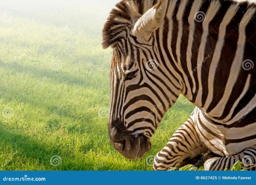

Folder data/animals/horse contains 57 files


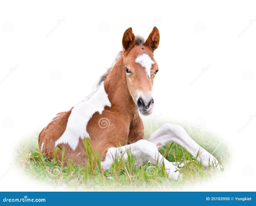

In [9]:
for a in animals:
    folder = (data_dir / a)
    files = list(folder.iterdir())
    print(f"Folder {folder} contains {len(files)} files")
    x = Image.open(files[0])
    x.thumbnail((256,256))
    display(x)

In [ ]:
# Download resnet and finetune 1 epoch
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

In [ ]:
# Run image cleaner

In [ ]:
# Re-run finetuning for 5 epochs